In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import shutil
import re
import math
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage import img_as_float32, img_as_ubyte
import pickle
import cv2

from albumentations import (
    Compose, HorizontalFlip, ShiftScaleRotate, ElasticTransform,
    RandomBrightness, RandomContrast, RandomGamma
)

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [2]:
reduce_learning_rate = keras.callbacks.ReduceLROnPlateau(
  monitor = "loss", 
  factor = 0.5, 
  patience = 3, 
  verbose = 1
)

checkpointer = keras.callbacks.ModelCheckpoint(
  "unet.h5", 
  verbose = 1, 
  save_best_only = True
)

# LOSS Functions
def jaccard_distance_loss(y_true, y_pred, smooth = 100):
    intersection = keras.backend.sum(keras.backend.abs(y_true * y_pred), axis = -1)
    union = keras.backend.sum(keras.backend.abs(y_true) + keras.backend.abs(y_pred), axis = -1)
    jac = (intersection + smooth) / (union - intersection + smooth)
    loss = (1 - jac) * smooth
    return loss

def dice_coef(y_true, y_pred, smooth = 1):
    intersection = keras.backend.sum(keras.backend.abs(y_true * y_pred), axis = -1)
    union = keras.backend.sum(keras.backend.abs(y_true), -1) + keras.backend.sum(keras.backend.abs(y_pred), -1)
    return (2. * intersection + smooth) / (union + smooth)

In [3]:
if (os.path.exists("unet.h5")):
  model = keras.models.load_model("unet.h5",
    custom_objects = {
      "jaccard_distance_loss": jaccard_distance_loss,
      "dice_coef": dice_coef
    }
  )
  

In [4]:
X_val = np.load('input/X_val.npy')
Y_val = np.load('input/Y_val.npy')

with open('input/epochs.txt', 'r') as file:
    steps_per_epoch = file.read().rstrip()

steps_per_epoch = int(steps_per_epoch)


In [5]:
iou_val, dice_val = model.evaluate(X_val, Y_val, verbose = False)


In [6]:
X_train = np.load('input/X_train.npy')
Y_train = np.load('input/Y_train.npy')

iou_train, dice_train = model.evaluate(X_train, Y_train, verbose = False)


In [7]:
X_test = np.load('input/X_test.npy')
Y_test = np.load('input/Y_test.npy')

iou_test, dice_test = model.evaluate(X_test, Y_test, verbose = False)



In [8]:
print("Jaccard distance (IoU) train: %f" % iou_train)
print("Dice coeffient train: %f" % dice_train)
print("Jaccard distance (IoU) validation: %f" % iou_val)
print("Dice coeffient validation: %f" % dice_val)
print("Jaccard distance (IoU) test: %f" % iou_test)
print("Dice coeffient test: %f" % dice_test)

Jaccard distance (IoU) train: 0.198845
Dice coeffient train: 0.899309
Jaccard distance (IoU) validation: 0.210787
Dice coeffient validation: 0.893283
Jaccard distance (IoU) test: 0.191380
Dice coeffient test: 0.903078


In [9]:
nimages = X_train.shape[0]
iou_train = []
dice_train = []
for idx in range(nimages):
  iou, dice = model.evaluate(X_train[idx:idx+1,:,:], Y_train[idx:idx+1,:,:], verbose = False)
  iou_train.append(iou)
  dice_train.append(dice)

print("Jaccard distance (IoU) train: %f (+-%f)" % (np.mean(iou_train), np.std(iou_train)))
print("Dice coeffient train: %f (+-%f)" % (np.mean(dice_train), np.std(dice_train)))

nimages = X_val.shape[0]
iou_val = []
dice_val = []
for idx in range(nimages):
  iou, dice = model.evaluate(X_val[idx:idx+1,:,:], Y_val[idx:idx+1,:,:], verbose = False)
  iou_val.append(iou)
  dice_val.append(dice)

print("Jaccard distance (IoU) validation: %f (+-%f)" % (np.mean(iou_val), np.std(iou_val)))
print("Dice coeffient validation: %f (+-%f)" % (np.mean(dice_val), np.std(dice_val)))


nimages = X_test.shape[0]
iou_test = []
dice_test = []
for idx in range(nimages):
  iou, dice = model.evaluate(X_test[idx:idx+1,:,:], Y_test[idx:idx+1,:,:], verbose = False)
  iou_test.append(iou)
  dice_test.append(dice)

print("Jaccard distance (IoU) test: %f (+-%f)" % (np.mean(iou_test), np.std(iou_test)))
print("Dice coeffient test: %f (+-%f)" % (np.mean(dice_test), np.std(dice_test)))


Jaccard distance (IoU) train: 0.198845 (+-0.111525)
Dice coeffient train: 0.899309 (+-0.056199)
Jaccard distance (IoU) validation: 0.210788 (+-0.105555)
Dice coeffient validation: 0.893283 (+-0.053236)
Jaccard distance (IoU) test: 0.191380 (+-0.113436)
Dice coeffient test: 0.903078 (+-0.057180)


ValueError: Images of type float must be between -1 and 1.

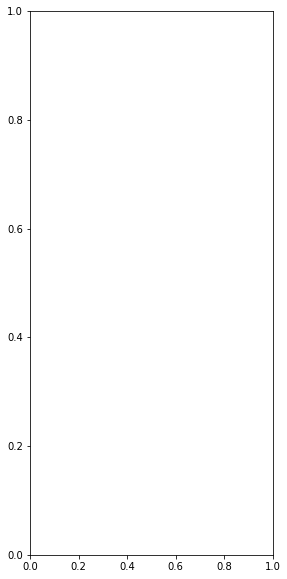

In [12]:
idx = 50
img_size = 400

test_img = X_test[idx,:,:,:].reshape((1, img_size, img_size, 1))
test_mask = Y_test[idx,:,:,:].reshape((1, img_size, img_size, 1))
pred_mask = model.predict(test_img)
pred_mask = np.uint8(pred_mask > 0.5)
post_pred_mask = skimage.morphology.erosion(pred_mask[0,:,:,0], skimage.morphology.square(5))
post_pred_mask = skimage.morphology.dilation(post_pred_mask, skimage.morphology.square(10))

f = plt.figure(figsize = (20, 10))
f.add_subplot(1, 4, 1)
plt.imshow(img_as_ubyte(test_img[0,:,:,0]), cmap = "gray")
f.add_subplot(1, 4, 2)
plt.imshow(test_mask[0,:,:,0], cmap = "gray")
f.add_subplot(1, 4, 3)
plt.imshow(pred_mask[0,:,:,0], cmap = "gray")
f.add_subplot(1, 4, 4)
plt.imshow(post_pred_mask, cmap = "gray")